# Figure: Covariates create effects at different scales

- Taxonomic PCA-flows annotated by
    - Continent
    - Surface
- Latitude vs Taxonomic Diversity
- Geographic vs. Taxonomic Distance


### Supplementary

- Geographic vs. Taxonomic Distance (alternative metrics)

In [1]:
%load_ext rpy2.ipython

import pandas as pd
from metasub_utils.packet_parse import MetaSUBTableFactory
from capalyzer.packet_parser.experimental import umap
import warnings

warnings.filterwarnings('ignore')

core_tabler = MetaSUBTableFactory.core_factory()

/home/dcdanko/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%%R

library(ggthemes)
library(ggplot2)
library(reshape2)
library(gridExtra)
library(ALDEx2)
library(RColorBrewer)

## Taxonomic PCA Flows

In [3]:
from sklearn.decomposition import PCA


taxa = core_tabler.taxonomy(normalize=True)

NPCS=100
pca = PCA(n_components=NPCS)
pcs = pca.fit_transform(taxa)
pcs = pd.DataFrame(data=pcs, index=taxa.index, columns=[f'PC{i}' for i in range(NPCS)])

In [4]:
pca.explained_variance_ratio_

array([0.28048909, 0.1570917 , 0.08196541, 0.03126971, 0.02841625,
       0.0254862 , 0.02146557, 0.02069068, 0.01980483, 0.01729128,
       0.0136474 , 0.01159795, 0.01008037, 0.00918025, 0.00895588,
       0.00879117, 0.00856039, 0.00820632, 0.00754097, 0.00665673,
       0.00637512, 0.00613183, 0.00573817, 0.00553071, 0.00525586,
       0.00504273, 0.00468462, 0.00459378, 0.00431432, 0.00420383,
       0.00411075, 0.00385897, 0.00377315, 0.00366593, 0.00353032,
       0.00345776, 0.00342394, 0.00337214, 0.00319854, 0.00317154,
       0.00301217, 0.00282885, 0.00280382, 0.00276213, 0.00259581,
       0.00249444, 0.00246138, 0.00227141, 0.00220765, 0.0021748 ,
       0.00210532, 0.00202743, 0.00199631, 0.00196208, 0.00194169,
       0.00189725, 0.00186886, 0.00185998, 0.00180707, 0.00179202,
       0.00176623, 0.00172001, 0.00166075, 0.00161464, 0.00158632,
       0.0015609 , 0.00154414, 0.00151567, 0.00150121, 0.00147762,
       0.00146581, 0.00144151, 0.00139458, 0.00134908, 0.00130

In [5]:
from metasub_utils.packet_parse import MetaSUBTableFactory

core_tabler = MetaSUBTableFactory.core_factory()
pcs['surface'] = core_tabler.metadata['surface_ontology_fine']
pcs['surface'] = [str(el) for el in pcs['surface']]

pcs['temperature'] = core_tabler.metadata['city_ave_june_temp_c']
pcs['pop_density'] = core_tabler.metadata['city_population_density']

pcs['continent'] = core_tabler.metadata['continent']
pcs['continent'] = [str(el) for el in pcs['continent']]

pcs['sample'] = [str(el) for el in pcs.index]
pcs = pcs.loc[pcs['surface'] != 'nan']
pcs = pcs.loc[pcs['surface'] != 'control']
pcs = pcs.loc[pcs['continent'] != '0']
foo = pcs.melt(id_vars=['surface', 'sample', 'temperature', 'pop_density', 'continent'])
print(foo.shape)
foo.head()

(243600, 7)


,surface,sample,temperature,pop_density,continent,variable,value
0,metal,haib17DB4959_H3MGVCCXY_SL259897,23.3,11000.0,north_america,PC0,-0.061781
1,plastic,haib18CEM5453_HMGTJCCXY_SL342605,21.7,2662.0,east_asia,PC0,0.378467
2,stone,haib18CEM5453_HNHKFCCXY_SL345587,30.3,6777.0,east_asia,PC0,-0.098933
3,metal,haib17CEM5080_H7VL7CCXY_SL267207,NaN,NaN,europe,PC0,-0.000162
4,metal,haib17DB4959_HMGTJCCXY_SL342584,22.2,1380.0,east_asia,PC0,0.064542


In [23]:
from math import log2
from scipy.stats import gmean

def sign(val):
    return 1 if val >= 0 else 0

def outlier_cropping_mean(s):
    low, high = s.quantile(0.1), s.quantile(0.99)
    s = s[s > low]
    s = s[s < high]
    return s.mean()

def scaleit(tbl):
    tbl = tbl.groupby('surface').mean()
    return tbl
    


bar = foo.groupby('variable').apply(scaleit)
bar['variable'] = [int(str(el[0]).split('PC')[1]) for el in bar.index]
bar['surface'] = [str(el[1]) for el in bar.index]
bar.head()

temperature  pop_density     value  variable     surface
variable surface                                                             
PC0      biological    20.928986  5155.602899 -0.022955         0  biological
         fabric        23.050000  1655.583333  0.056031         0      fabric
         metal         23.227240  6432.236994  0.002597         0       metal
         plastic       24.301659  5588.409953  0.025721         0     plastic
         stone         28.340120  6347.544910 -0.069477         0       stone

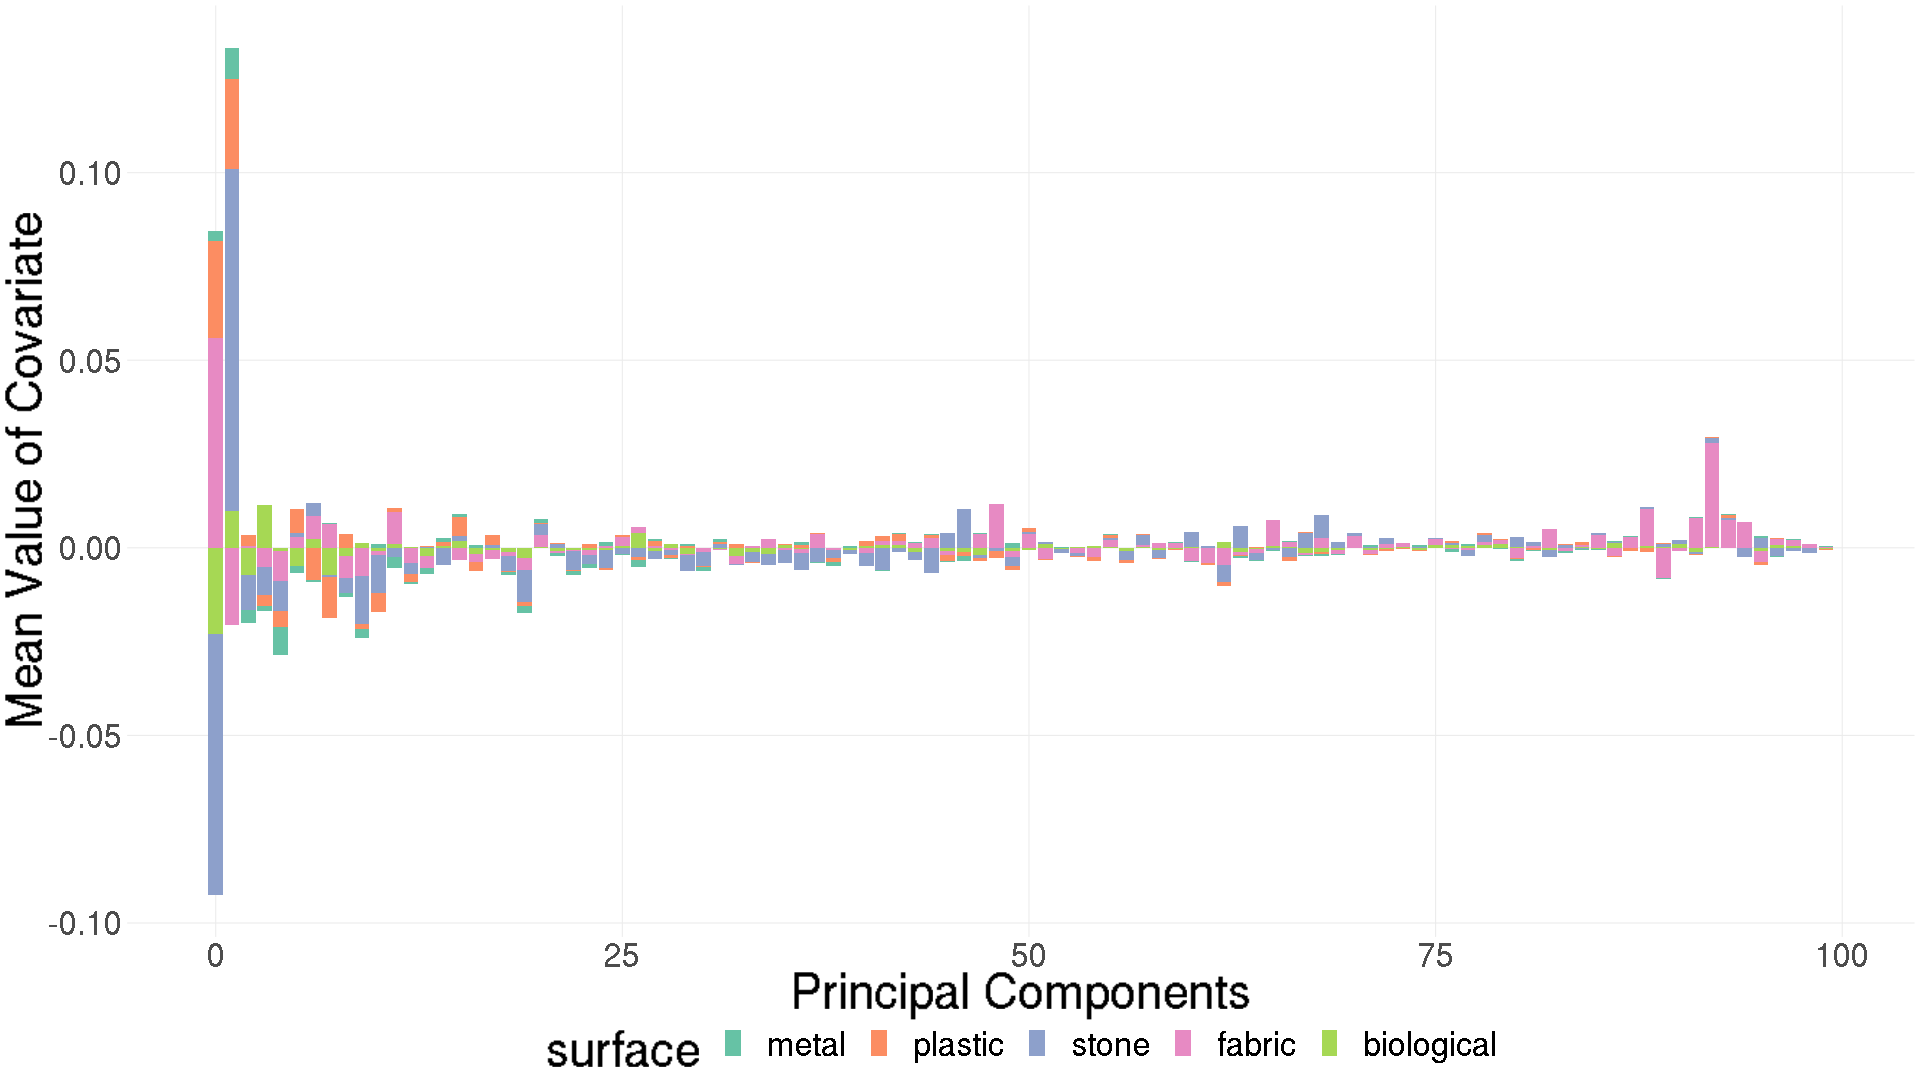

In [25]:
%%R -i bar -w 1920 -h 1080

bar$surface = ordered(bar$surface, levels=c('metal', 'plastic', 'stone', 'fabric', 'biological'))
ggplot(bar, aes(x=variable, y=value, fill=surface)) +
    geom_bar(stat='identity') +
    theme_minimal() +
    scale_fill_brewer(palette='Set2') +
    #scale_y_continuous(trans=reverselog_trans(base=2), labels=trans_format("identity", function(x) -x)) +
    xlab('Principal Components') +
    ylab('Mean Value of Covariate') +
    theme(
        text = element_text(size=50),
        #panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        #axis.text.x=element_text(angle=90, size=25),
        #axis.title.x=element_blank(),
        #axis.text.y=element_blank(),
        #axis.title.y=element_blank(),
    )

In [17]:
from math import log2

def sign(val):
    return 1 if val >= 0 else 0

def scaleit(tbl):
    return tbl.groupby('continent').mean()
    


bar = foo.groupby('variable').apply(scaleit)
bar['variable'] = [int(str(el[0]).split('PC')[1]) for el in bar.index]
bar['continent'] = [str(el[1]) for el in bar.index]
bar.head()

temperature   pop_density     value  variable  \
variable continent                                                      
PC0      east_asia        28.469832   7138.005935  0.005741         0   
         europe           16.543020   5420.815990 -0.000260         0   
         middle_east      37.500000  10000.000000 -0.032413         0   
         nan                    NaN           NaN  0.008519         0   
         north_america    22.674372   6714.527638  0.044345         0   

                            continent  
variable continent                     
PC0      east_asia          east_asia  
         europe                europe  
         middle_east      middle_east  
         nan                      nan  
         north_america  north_america

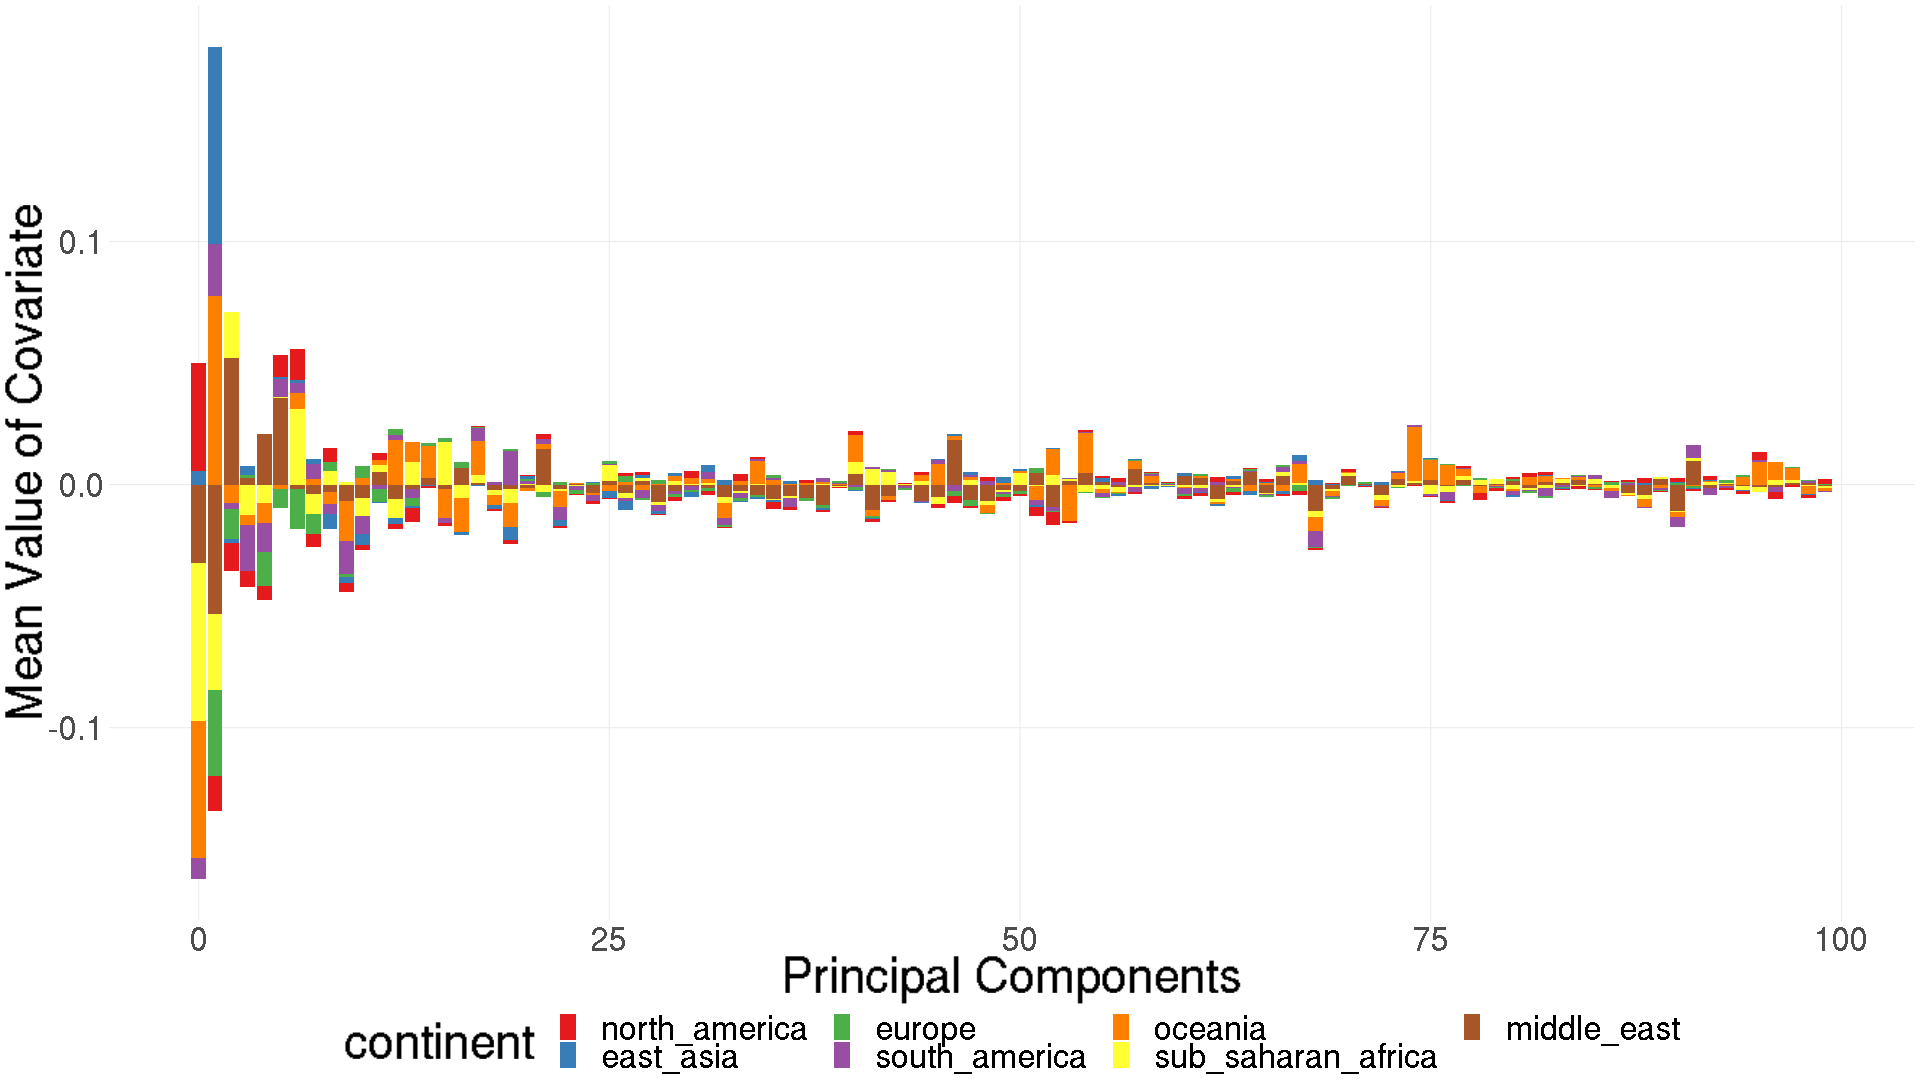

In [22]:
%%R -i bar -w 1920 -h 1080

bar$continent = ordered(
    bar$continent,
    levels=c(
        'north_america',
        'east_asia',
        'europe',
        'south_america',
        'oceania',
        'sub_saharan_africa',
        'middle_east'
)
)
bar = bar[!is.na(bar$continent),]
ggplot(bar, aes(x=variable, y=value, fill=continent)) +
    geom_bar(stat='identity') +
    theme_minimal() +
    scale_fill_brewer(palette='Set1') +
    #scale_y_continuous(trans=reverselog_trans(base=2), labels=trans_format("identity", function(x) -x)) +
    xlab('Principal Components') +
    ylab('Mean Value of Covariate') +
    theme(
        text = element_text(size=50),
        #panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position='bottom',
        #axis.text.x=element_blank(),
        #axis.title.x=element_blank(),
        #axis.text.y=element_blank(),
        #axis.title.y=element_blank(),
    )

## Geographic vs Taxonomic Distance

In [28]:
from os.path import isfile

FNAME = '.taxa_jsd_cache.csv'
if isfile(FNAME):
    taxa_jsd = pd.read_csv(FNAME)
else:
    taxa_jsd = core_tabler.taxa_beta_diversity()
    taxa_jsd.to_csv(FNAME)

In [29]:
taxa_jsd.iloc[0:3, 0:3]

uuid,haib17DB4959_H3MGVCCXY_SL259897,haib17CEM5106_HCVMTCCXY_SL269613,haib18CEM5453_HMGTJCCXY_SL342605
uuid,,,
haib17DB4959_H3MGVCCXY_SL259897,0.000000,0.794278,0.596571
haib17CEM5106_HCVMTCCXY_SL269613,0.794278,0.000000,0.739092
haib18CEM5453_HMGTJCCXY_SL342605,0.596571,0.739092,0.000000


In [30]:
from math import sin, cos, sqrt, atan2
from scipy.spatial.distance import squareform, pdist
from itertools import combinations


def gdist(r1, r2):
    R = 6373.0
    dlon, lon2, lon1 = r2[1] - r1[1], r2[1], r1[1]
    dlat, lat2, lat1 = r2[0] - r1[0], r2[0], r1[0]
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

def geodists(samples):
    """Small so just use euclidean distance"""
    coords = core_tabler.metadata.loc[samples, ['latitude', 'longitude']]
    coords = coords.dropna()
    coords = coords.query('abs(latitude) > 0')
    gdists = pd.DataFrame(squareform(pdist(coords, gdist)), columns=coords.index, index=coords.index)
    return gdists
    
def elongate(city, jsd, geo):
    tbl = {}
    for s1, s2 in combinations(jsd.index, 2):
        j = jsd.loc[s1, s2]
        g = geo.loc[s1, s2]
        tbl[(city, s1, s2)] = {'jsd': j, 'geo': g, 'city': city}
    return pd.DataFrame.from_dict(tbl, orient='index')


In [31]:
all_dist_samples = set(taxa_jsd.index) & set(core_tabler.metadata.query('abs(latitude) > 0').index)
tbls = []
for city in core_tabler.metadata['city'].unique():
    samples = core_tabler.metadata.query(f'city == "{city}"').index
    samples = set(samples) & all_dist_samples
    if len(samples) == 0:
        continue
    city_taxa_dists = taxa_jsd.loc[samples, samples]
    city_geo_dists = geodists(samples)
    tbls.append(elongate(city, city_taxa_dists, city_geo_dists))

dist_pairs = pd.concat(tbls)
dist_pairs = dist_pairs.query('geo < 50').query('geo > 1')
dist_pairs.head()

jsd  \
berlin haib17CEM4890_H7KYMCCXY_SL273042 haib17CEM4890_H7KYMCCXY_SL273113  0.260373   
       haib17CEM4890_H7KYMCCXY_SL273066 haib17CEM4890_H7KYMCCXY_SL273042  0.168765   
                                        haib17CEM4890_H7KYMCCXY_SL273113  0.246379   
       haib17CEM4890_H7KYMCCXY_SL273125 haib17CEM4890_H7KYMCCXY_SL273042  0.235989   
                                        haib17CEM4890_H7KYMCCXY_SL273066  0.254202   

                                                                                geo  \
berlin haib17CEM4890_H7KYMCCXY_SL273042 haib17CEM4890_H7KYMCCXY_SL273113  35.703951   
       haib17CEM4890_H7KYMCCXY_SL273066 haib17CEM4890_H7KYMCCXY_SL273042  28.549555   
                                        haib17CEM4890_H7KYMCCXY_SL273113   9.502668   
       haib17CEM4890_H7KYMCCXY_SL273125 haib17CEM4890_H7KYMCCXY_SL273042  35.703951   
                                        haib17CEM4890_H7KYMCCXY_SL273066   9.502668   

                                                                            city  
berlin haib17CEM4890_H7KYMCCXY_SL273042 haib17CEM4890_H7KYMCCXY_SL273113  berlin  
       haib17CEM4890_H7KYMCCXY_SL273066 haib17CEM4890_H7KYMCCXY_SL273042  berlin  
                                        haib17CEM4890_H7KYMCCXY_SL273113  berlin  
       haib17CEM4890_H7KYMCCXY_SL273125 haib17CEM4890_H7KYMCCXY_SL273042  berlin  
                                        haib17CEM4890_H7KYMCCXY_SL273066  berlin

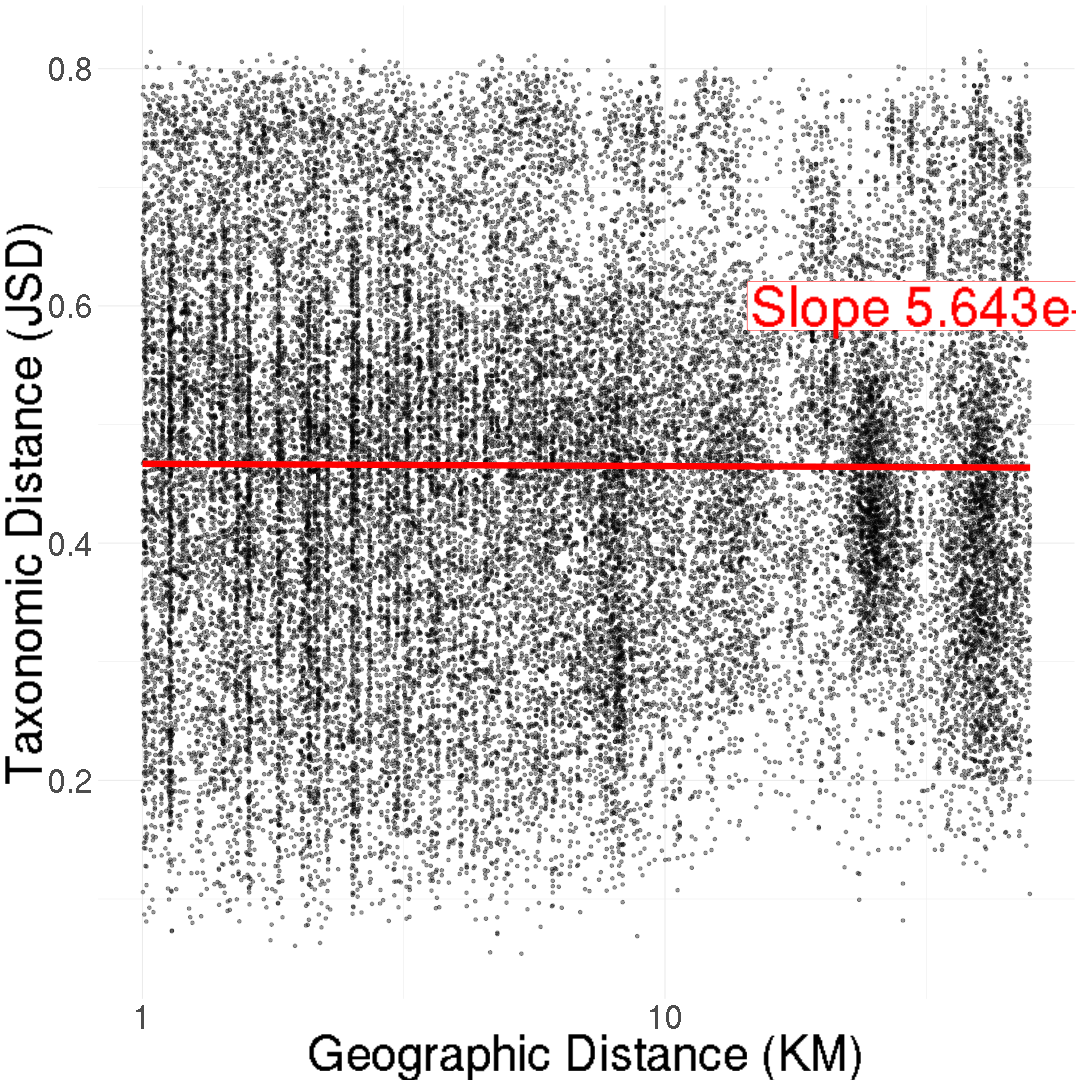

In [32]:
%%R  -i dist_pairs -w 1080 -h 1080

ann_text = data.frame(
    geo=35,
    jsd=0.6
)

ggplot(dist_pairs, aes(y=jsd, x=geo)) +
    geom_point(alpha=0.4) +
    #geom_density_2d(size=1, color='blue') +
    scale_x_log10() +
    geom_smooth(method='lm', color='red', size=3) +
    ylab('Taxonomic Distance (JSD)') +
    xlab('Geographic Distance (KM)') +
    theme_minimal() +
    geom_label(data=ann_text, label="Slope 5.643e-04", size=20, color='red') +
    theme(
        text = element_text(size=50),
    )

In [33]:
%%R

fit = lm(jsd ~ geo, data=dist_pairs)
summary(fit)


Call:
lm(formula = jsd ~ geo, data = dist_pairs)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.41155 -0.11606 -0.00114  0.11098  0.34973 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.655e-01  1.133e-03  410.83   <2e-16 ***
geo         -7.186e-06  6.553e-05   -0.11    0.913    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1588 on 34699 degrees of freedom
Multiple R-squared:  3.466e-07,	Adjusted R-squared:  -2.847e-05 
F-statistic: 0.01203 on 1 and 34699 DF,  p-value: 0.9127



## Latitude vs. Taxonomic Diversity

In [34]:
taxa = core_tabler.taxonomy()
entropy = core_tabler.alpha_diversity(taxa, metric='shannon_entropy')
richness = core_tabler.alpha_diversity(taxa, metric='richness', rarefy=1000000)
diversity = pd.concat([entropy, richness, core_tabler.metadata['latitude'], core_tabler.metadata['city']], axis=1)
diversity.columns = ['entropy', 'richness', 'lat', 'city']
diversity = diversity.query('abs(lat) > 0')
coarse_factor = 2
diversity['coarse'] = coarse_factor * (diversity['lat'] // coarse_factor)
diversity['abs_lat'] = abs(diversity['lat'])
diversity['abs_coarse'] = abs(coarse_factor * (diversity['lat'] // coarse_factor))
diversity.head()

,entropy,richness,lat,city,coarse,abs_lat,abs_coarse
haib17CEM4890_H2NYMCCXY_SL254769,3.007354,1125.0,8.154848,offa,8.0,8.154848,8.0
haib17CEM4890_H2NYMCCXY_SL254770,5.094928,1610.0,8.154850,offa,8.0,8.154850,8.0
haib17CEM4890_H2NYMCCXY_SL254771,3.754619,1473.0,8.154992,offa,8.0,8.154992,8.0
haib17CEM4890_H2NYMCCXY_SL254772,2.968513,1382.0,8.156144,offa,8.0,8.156144,8.0
haib17CEM4890_H2NYMCCXY_SL254773,8.200204,2276.0,40.713175,new_york_city,40.0,40.713175,40.0


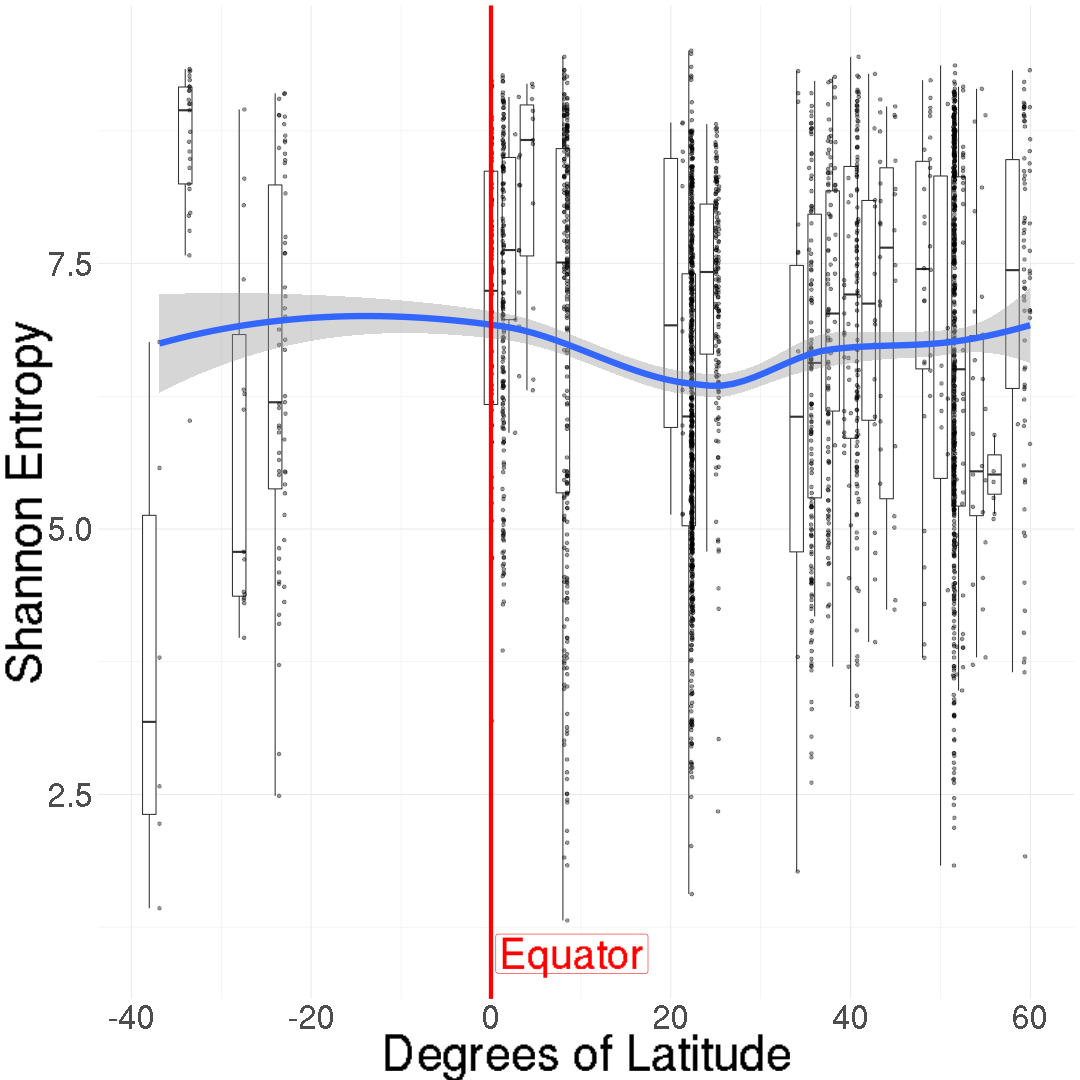

In [35]:
%%R -i diversity -w 1080 -h 1080

ann_text = data.frame(
    coarse=9,
    entropy=1
)
ggplot(diversity, aes(x=coarse, y=entropy, group=coarse)) +
    geom_boxplot( outlier.shape=NA) +
    geom_point(aes(x=lat), alpha=0.4) +
    geom_smooth(method='loess', aes(x=lat, y=entropy), inherit.aes=F, size=3) +
    ylab('Shannon Entropy') +
    xlab('Degrees of Latitude') +
    theme_minimal() +
    geom_vline(xintercept=0, col='red', size=2, label='Equator') +
    geom_label(data=ann_text, label="Equator", size=15, color='red') +
    theme(
        text = element_text(size=50),
    )

In [36]:
%%R

fit = lm(entropy ~ abs_lat, data=diversity)
summary(fit)


Call:
lm(formula = entropy ~ abs_lat, data = diversity)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.4015 -1.2174  0.1407  1.4421  2.8162 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.730393   0.064714 104.002   <2e-16 ***
abs_lat     -0.001847   0.001859  -0.993    0.321    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.66 on 2632 degrees of freedom
  (37 observations deleted due to missingness)
Multiple R-squared:  0.0003749,	Adjusted R-squared:  -4.927e-06 
F-statistic: 0.987 on 1 and 2632 DF,  p-value: 0.3206



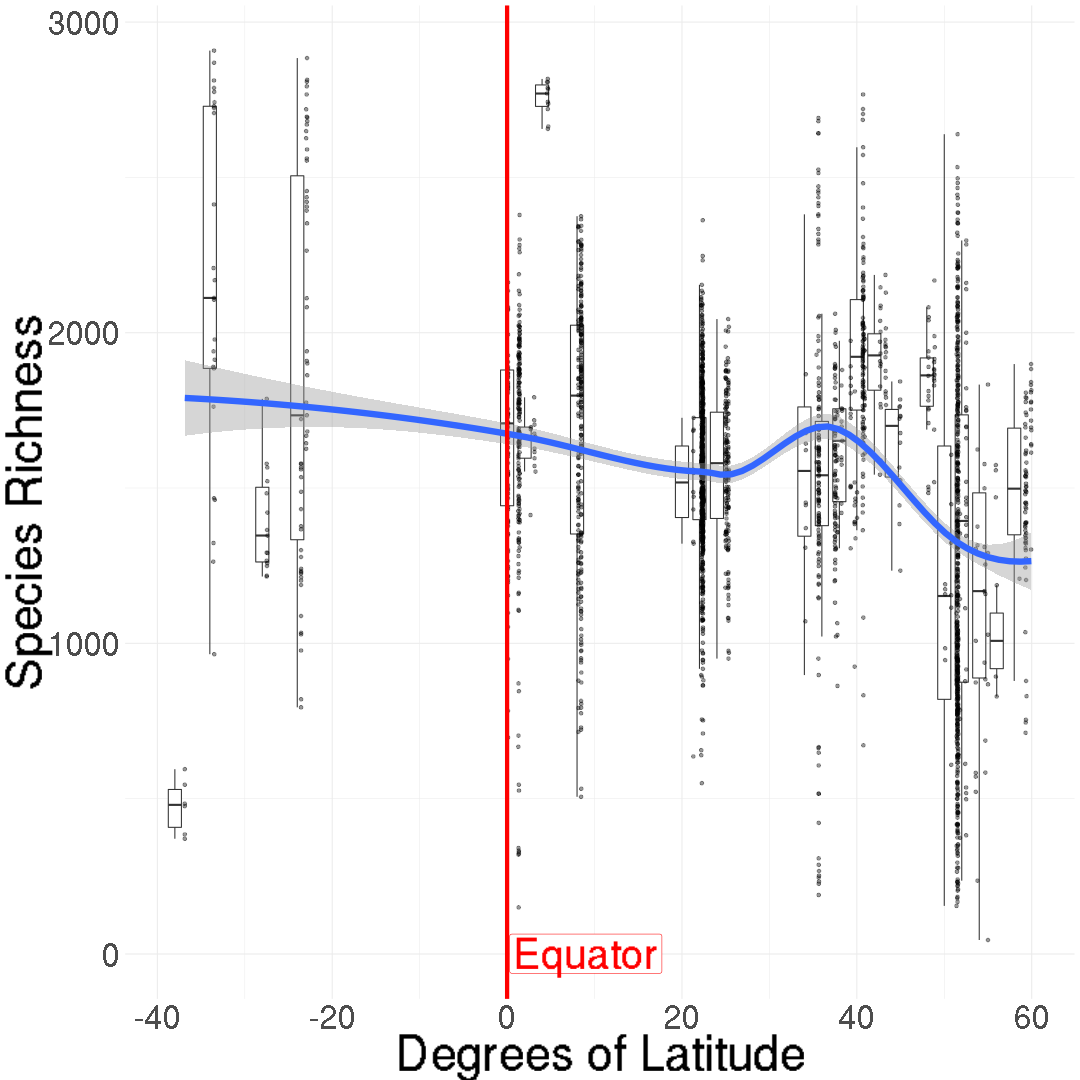

In [37]:
%%R -i diversity -w 1080 -h 1080

ann_text = data.frame(
    coarse=9,
    richness=1
)
ggplot(diversity, aes(x=coarse, y=richness, group=coarse)) +
    geom_boxplot(outlier.shape=NA) +
    geom_point(aes(x=lat), alpha=0.4) +
    geom_smooth(method='loess', aes(x=lat, y=richness), inherit.aes=F, size=3) +
    ylab('Species Richness') +
    xlab('Degrees of Latitude') +
    theme_minimal() +
    geom_vline(xintercept=0, col='red', size=2, label='Equator') +
    geom_label(data=ann_text, label="Equator", size=15, color='red') +
    theme(
        text = element_text(size=50),
    )

In [38]:
taxa = core_tabler.taxonomy(normalize=False)


print(taxa.shape)

design = core_tabler.metadata.loc[taxa.index, ['continent', 'surface_ontology_fine', 'city_population_density', 'city_ave_june_temp_c', 'coastal_city', 'city_elevation_meters']].fillna('unknown')
design['continent'] = [str(el) for el in design['continent']]
design['surface_ontology_fine'] = [str(el) for el in design['surface_ontology_fine']]
design = design.query('continent != "0"').query('city_population_density > 0')
taxa = taxa.loc[design.index]

taxa_prev = (taxa > 0).mean()
taxa = taxa[taxa_prev[taxa_prev > 0.25].index]
taxa += 1

print(taxa.shape)
print(design.shape)
design.head()

(3639, 4424)


TypeError: '>' not supported between instances of 'str' and 'int'

In [ ]:
design.corr()

In [ ]:
%%R -i taxa -i design

devtools::load_all('/home/dcdanko/Dev/mavric/')

mav = estVC(t(taxa), design, clist, verbose=T, autosel=F, sigcor=F)

In [6]:
%%R
        
design$continent = as.factor(design$continent)
design$surface_ontology_fine = as.factor(design$surface_ontology_fine)
design$coastal_city = as.factor(design$coastal_city)

plotVars(mav, design, plotve=F)

                                                    city_ave_june_temp_c\n4%&city_population_density\n0%&coastal_city\n2%&continent\n11% 
                                                                                                                             0.002908082 
                                                                     city_ave_june_temp_c\n4%&city_population_density\n0%&continent\n11% 
                                                                                                                             0.003681108 
                                                                             city_population_density\n0%&coastal_city\n2%&continent\n11% 
                                                                                                                             0.006329686 
                                                                                              city_population_density\n0%&continent\n11% 
                                  

In [13]:
vals = pd.Series({
    'city_population_density': 0,
    'city_ave_june_temp_c ': 4,
    'city_elevation_meters': 4,
    'coastal_city ': 2,
    'surface_ontology_fine': 3, 
    'continent': 11,                                                                                                                   
})
list(vals.index)

['city_population_density',
 'city_ave_june_temp_c ',
 'city_elevation_meters',
 'coastal_city ',
 'surface_ontology_fine',
 'continent']

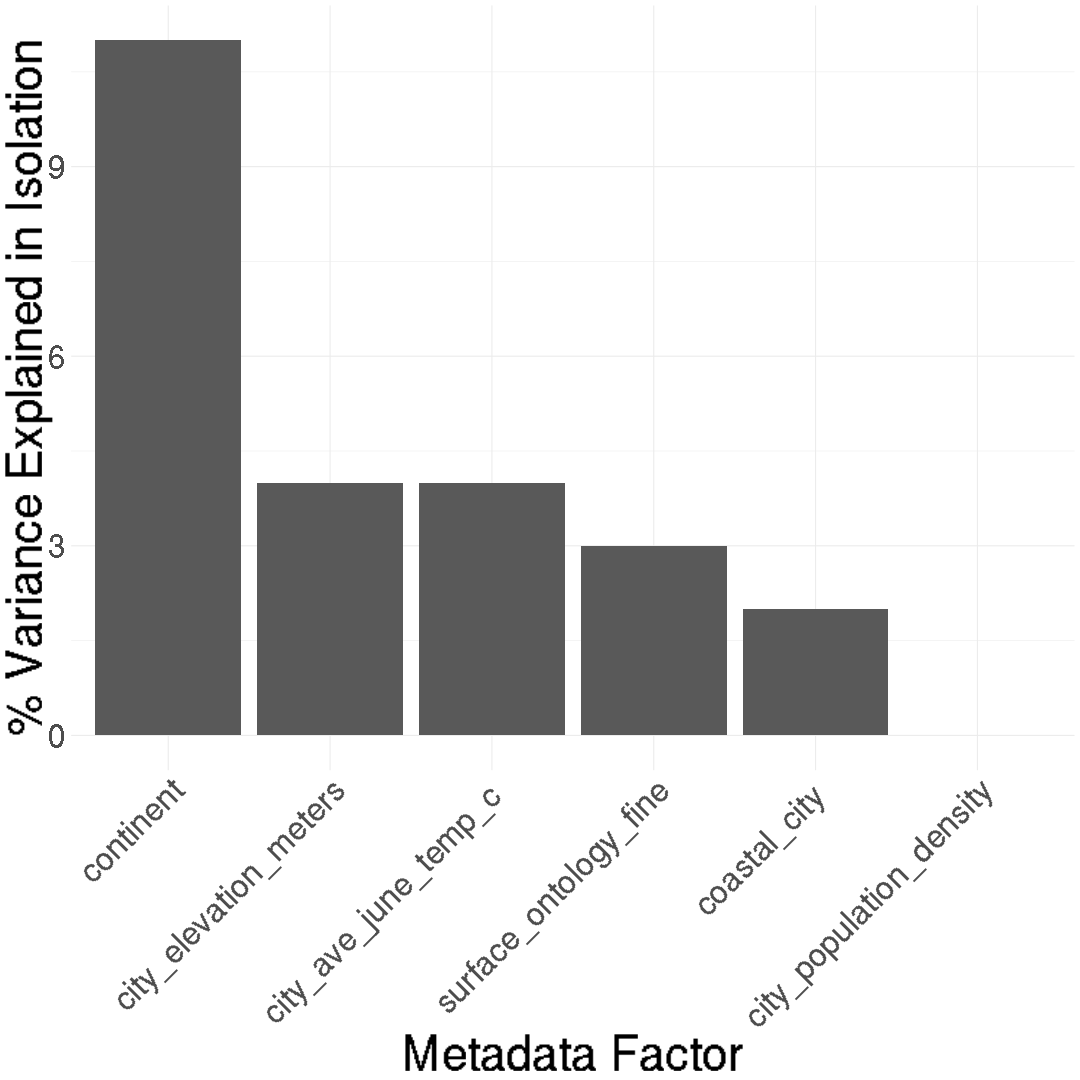

In [19]:
%%R -i vals  -w 1080 -h 1080

vals = data.frame(vals)
vals$kind = ordered(rownames(vals), levels=rev(c('city_population_density',
 'coastal_city ',
 'surface_ontology_fine',
 'city_ave_june_temp_c ',
 'city_elevation_meters',
 'continent'
)))

ggplot(vals, aes(x=kind, y=vals)) +
    geom_col() +
    ylab('% Variance Explained in Isolation') +
    xlab('Metadata Factor') +
    theme_minimal() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1),
        text = element_text(size=50),
    )